In [7]:
import cv2
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt

In [8]:
file_names = [
    "img/26_知覚データを取得する2.jpg",
    "img/31_知覚データを取得する2.jpg",
    "img/36_知覚データを取得する2.jpg",
    "img/37_知覚データを取得する2.jpg",
    "img/38_知覚データを取得する3.jpg",
    "img/39_知覚データを取得する2.jpg",
    "img/39_知覚データを取得する3.jpg",
    "img/40_知覚データを取得する2.jpg",
    "img/40_知覚データを取得する3.jpg",
    "img/42_知覚データを取得する2.jpg",
    "img/42_知覚データを取得する3.jpg",
    "img/43_知覚データを取得する2.jpg",
    "img/43_知覚データを取得する3.jpg",
    "img/44_知覚データを取得する2.jpg"
]

In [60]:
row = 2
col = 2

def analysis(img_name):
    fix, ax = plt.subplots(row, col, figsize=(10, 7))

    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0, 0].imshow(img)

    img2 = cv2.GaussianBlur(img, (5, 5), 0)
    ax[0, 1].imshow(img2)

    img3 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    img3 = cv2.inRange(img3, (95, 50, 50), (125, 255, 255))
    ax[1, 0].imshow(img3)

    contours, hierarchy = cv2.findContours(img3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 

    img4 = img.copy()
    
    # 最小面積でフィルタリング（オプション）
    min_area = 2  # 最小面積の閾値
    
    img5 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # 輪郭ごとの処理
    target_x = 0
    target_y = 0
    for i, contour in enumerate(contours):
        # 輪郭の面積を事前にチェック
        area = cv2.contourArea(contour)
        
        # 最小面積以上の輪郭のみ処理
        if area >= min_area:
            # 重心の計算
            m = cv2.moments(contour)
            
            # モーメントが0でない場合のみ重心を計算
            if m['m00'] != 0:
                x, y= m['m10']/m['m00'] , m['m01']/m['m00']
                # 座標を四捨五入
                x, y = round(x), round(y)

                ## 重心の周辺に輪っかがあることを調べる
                ## この方法は縁の端っこが画面外の時は検出できない
                ## 円に一番近い内側の1つの円だけに注目する
                ## 2, 3重円を検出しようとすると、画面外の問題で検出ハードルが上がってしまう（誤検出は減るだろうね）

                scan = 1
                left_peak = 0
                right_peak = 0
                prev_left_bright = img5[y, x]
                prev_prev_left_bright = img5[y, x]
                prev_right_bright = img5[y, x]
                prev_prev_right_bright = img5[y, x]
                while (True):
                    left = x - scan
                    right = x + scan
                    if (left < 0) or (right >= img.shape[1]):
                        # 画面外は諦める
                        break

                    if left_peak == 0:
                        # まだ左のピークを探索中
                        # uint8のアンダーフローを防ぐためint型にキャスト
                        diff_left = (int(img5[y, left]) - int(prev_left_bright)) + (int(prev_left_bright) - int(prev_prev_left_bright))
                        if diff_left < -3:
                            left_peak = left

                    if right_peak == 0:
                        # まだ右のピークを探索中
                        # uint8のアンダーフローを防ぐためint型にキャスト
                        diff_right = (int(img5[y, right]) - int(prev_right_bright)) + (int(prev_right_bright) - int(prev_prev_right_bright))
                        if diff_right < -3:
                            right_peak = right

                    if (left_peak != 0) and (right_peak != 0):
                        # 重心の左右の円の縁を検出
                        if (((right_peak - x) * 0.9) < (x - left_peak)) and ((x - left_peak) < ((right_peak - x) * 1.1)):
                            # 重心を中心として正円がまとわりついている
                            # これはターゲットサークルに違いない
                            target_x = x
                            target_y = y
                             # 重心位置に x印を書く
                            cv2.line(img4, (x - 5, y - 5), (x + 5, y + 5), (255, 255, 127), 2)
                            cv2.line(img4, (x + 5, y - 5), (x - 5, y + 5), (255, 255, 127), 2)
                            print((right_peak - x), (x - left_peak))
                        break

                    # 玉ねぎの皮みたいに
                    # 内側から1枚ずつ円を探してみる
                    scan = scan + 1
                    # 前回の明るさを記録する
                    prev_prev_left_bright = prev_left_bright
                    prev_left_bright = img5[y, left]
                    prev_prev_right_bright = prev_right_bright
                    prev_right_bright = img5[y, right]

                """
                # ここからプロットピーク(左)の判定
                found_center_end_edge = False
                found_first_peak_start_edge = False
                found_first_peak_end_edge = False
                found_second_peak_start_edge = False

                distance_center_2_first = 0
                distance_first_2_second = 0

                for j in range(x, 0, -1):
                    if found_center_end_edge == False:
                        # まだ中心を抜け出せていない
                        if img5[y, j] < 127:
                            # 暗いところ
                            # まだ中心を抜け出せていない
                            # found_center_end_edge = False
                            pass
                        else:
                            # 明るいところ
                            # 中心を抜けた出した
                            found_center_end_edge = True
                    elif found_first_peak_start_edge == False:
                        # まだ最初のピークを発見できていない
                        if img5[y, j] > 127:
                            # 明るいところ
                            # まだ最初のピークに辿り着いていない
                            # found_first_peak_start_edge = False
                            distance_center_2_first = distance_center_2_first + 1
                            pass
                        else:
                            # 暗いところ
                            # 中心左手に最初のピークを発見した
                            found_first_peak_start_edge = True
                    elif found_first_peak_end_edge == False:
                        # まだ最初のピークを抜け出せていない
                        if img5[y, j] < 127:
                            # 暗いところ
                            # まだ最初のピークを抜け出せていない
                            # found_first_peak_end_edge = False
                            pass
                        else:
                            # 明るいところ
                            # 最初のピークを抜け出した
                            found_first_peak_end_edge = True
                    elif found_second_peak_start_edge == False:
                        # まだ2番目のピークを発見できていない
                        if img5[y, j] > 127:
                            # 明るいところ
                            # まだ2番目のピークを発見できていない
                            # found_second_peak_start_edge = False
                            distance_first_2_second = distance_first_2_second + 1
                            pass
                        else:
                            # 暗いところ
                            # 2番目のピークを発見した
                            found_second_peak_start_edge = True
                    else:
                        # 2回分ピークを発見したのでもう探索不要
                        break
                
                if (distance_center_2_first > 0) and (distance_first_2_second > 0):
                    # プロットピーク(左)の判定が完了した
                    if ((distance_center_2_first * 3 / 4) < distance_first_2_second) and (distance_first_2_second < (distance_center_2_first * 5 / 4)):
                        # 中心から2つのピークを発見したので、これはターゲットサークルである
                        target_x = x
                        target_y = y

                        # 重心位置に x印を書く
                        cv2.line(img4, (x-5,y-5), (x+5,y+5), (255, 255, 127), 2)
                        cv2.line(img4, (x+5,y-5), (x-5,y+5), (255, 255, 127), 2)
                        break
                
                # ここからプロットピーク(左)の判定
                found_center_end_edge = False
                found_first_peak_start_edge = False
                found_first_peak_end_edge = False
                found_second_peak_start_edge = False

                distance_center_2_first = 0
                distance_first_2_second = 0

                for j in range(x, img.shape[1], +1):
                    if found_center_end_edge == False:
                        # まだ中心を抜け出せていない
                        if img5[y, j] < 127:
                            # 暗いところ
                            # まだ中心を抜け出せていない
                            # found_center_end_edge = False
                            pass
                        else:
                            # 明るいところ
                            # 中心を抜けた出した
                            found_center_end_edge = True
                    elif found_first_peak_start_edge == False:
                        # まだ最初のピークを発見できていない
                        if img5[y, j] > 127:
                            # 明るいところ
                            # まだ最初のピークに辿り着いていない
                            # found_first_peak_start_edge = False
                            distance_center_2_first = distance_center_2_first + 1
                            pass
                        else:
                            # 暗いところ
                            # 中心左手に最初のピークを発見した
                            found_first_peak_start_edge = True
                    elif found_first_peak_end_edge == False:
                        # まだ最初のピークを抜け出せていない
                        if img5[y, j] < 127:
                            # 暗いところ
                            # まだ最初のピークを抜け出せていない
                            # found_first_peak_end_edge = False
                            pass
                        else:
                            # 明るいところ
                            # 最初のピークを抜け出した
                            found_first_peak_end_edge = True
                    elif found_second_peak_start_edge == False:
                        # まだ2番目のピークを発見できていない
                        if img5[y, j] > 127:
                            # 明るいところ
                            # まだ2番目のピークを発見できていない
                            # found_second_peak_start_edge = False
                            distance_first_2_second = distance_first_2_second + 1
                            pass
                        else:
                            # 暗いところ
                            # 2番目のピークを発見した
                            found_second_peak_start_edge = True
                    else:
                        # 2回分ピークを発見したのでもう探索不要
                        break
                
                if (distance_center_2_first > 0) and (distance_first_2_second > 0):
                    # プロットピーク(左)の判定が完了した
                    if ((distance_center_2_first * 3 / 4) < distance_first_2_second) and (distance_first_2_second < (distance_center_2_first * 5 / 4)):
                        # 中心から2つのピークを発見したので、これはターゲットサークルである
                        target_x = x
                        target_y = y

                        # 重心位置に x印を書く
                        cv2.line(img4, (x-5,y-5), (x+5,y+5), (255, 255, 127), 2)
                        cv2.line(img4, (x+5,y-5), (x-5,y+5), (255, 255, 127), 2)
                        break
                """
            else:
                # print(f"Contour {i}: Empty contour (m00 = 0) - skipping centroid calculation")
                pass
        else:
            # print(f"Contour {i}: Small contour (area = {area}) - skipped")
            pass

    ax[1, 1].imshow(img4)


img/26_知覚データを取得する2.jpg
41 41
img/31_知覚データを取得する2.jpg
32 33
img/36_知覚データを取得する2.jpg
32 34
img/37_知覚データを取得する2.jpg
img/38_知覚データを取得する3.jpg
img/39_知覚データを取得する2.jpg
img/39_知覚データを取得する3.jpg
img/40_知覚データを取得する2.jpg
28 29
img/40_知覚データを取得する3.jpg
img/42_知覚データを取得する2.jpg
img/42_知覚データを取得する3.jpg
40 43
img/43_知覚データを取得する2.jpg
41 41
img/43_知覚データを取得する3.jpg
43 42
img/44_知覚データを取得する2.jpg
42 41


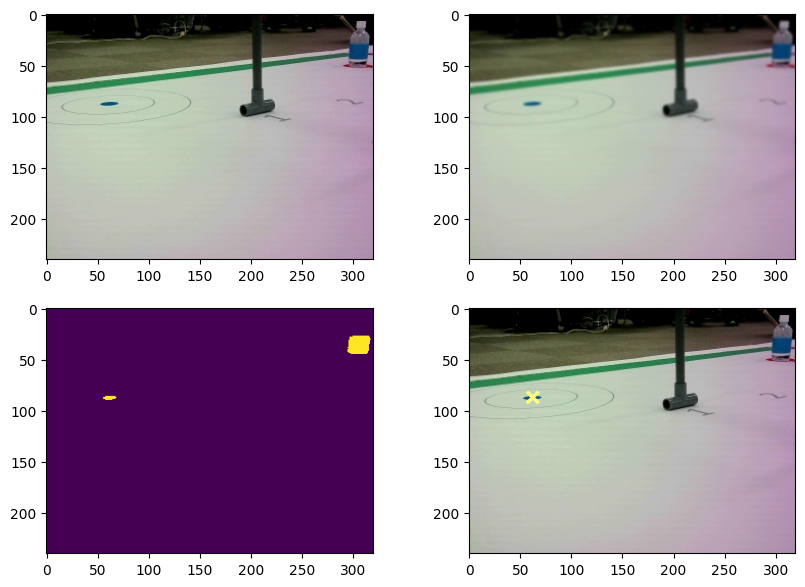

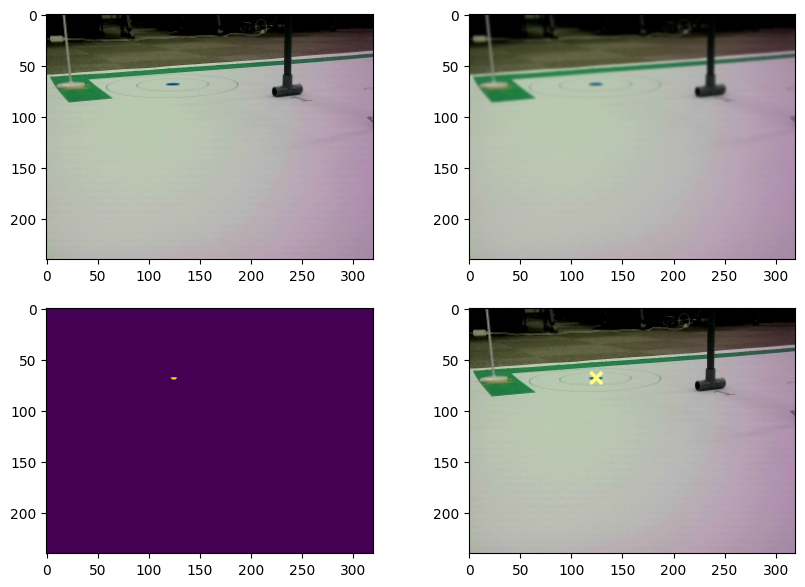

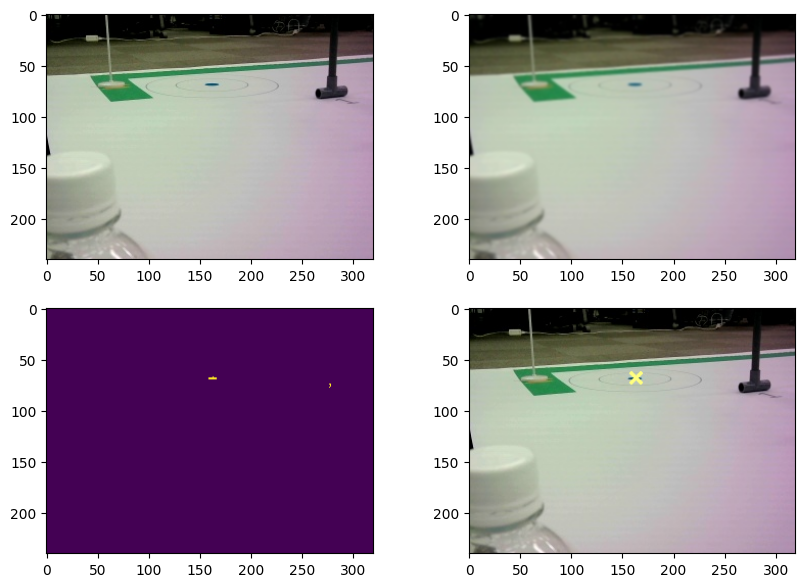

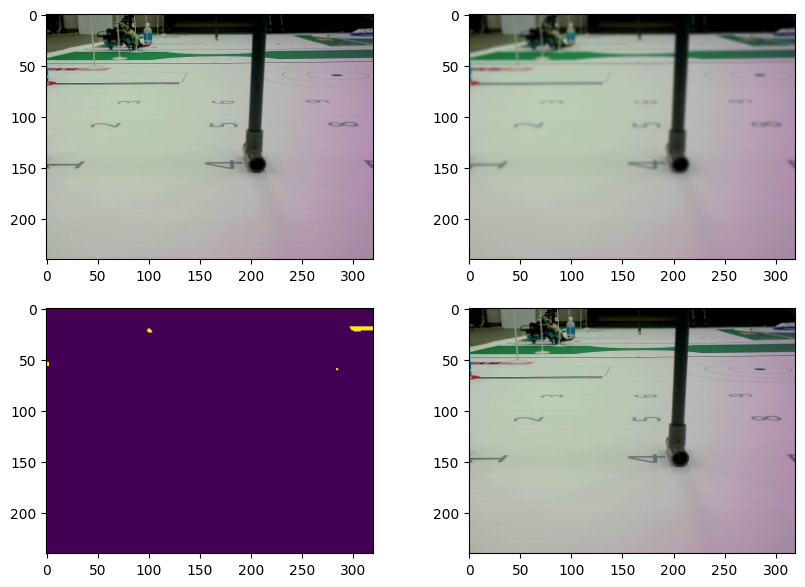

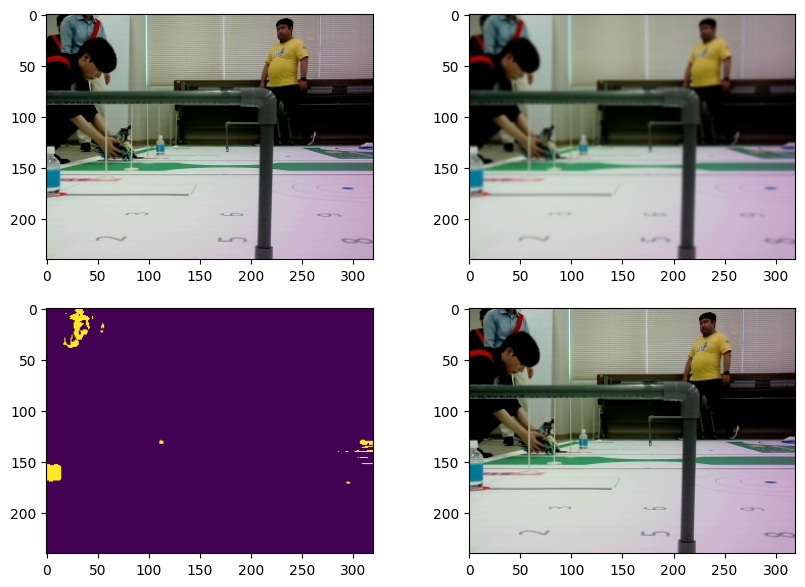

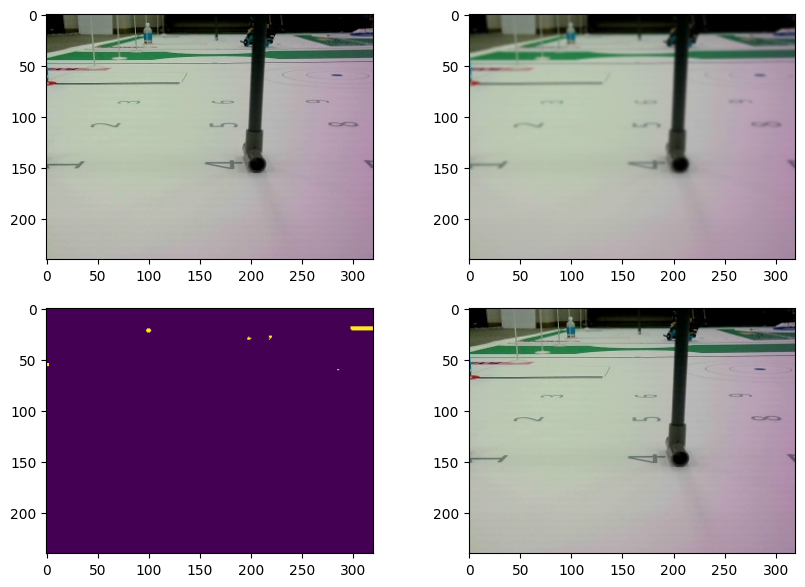

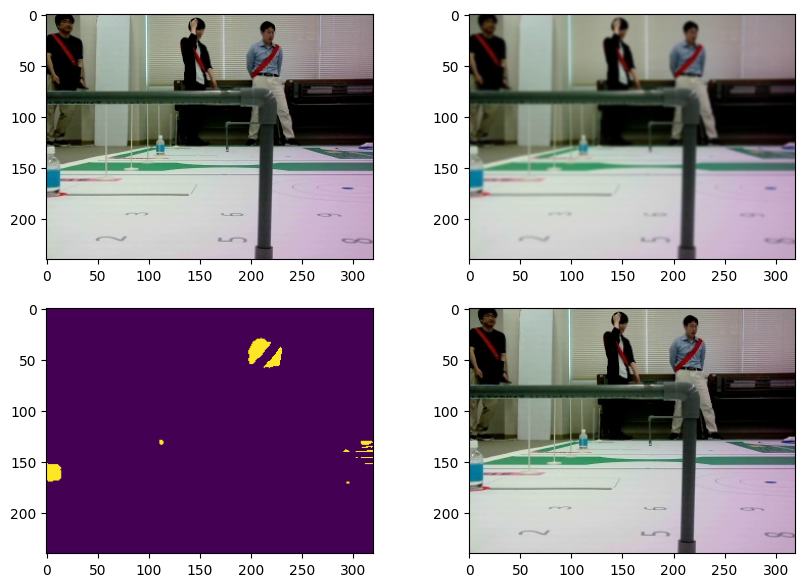

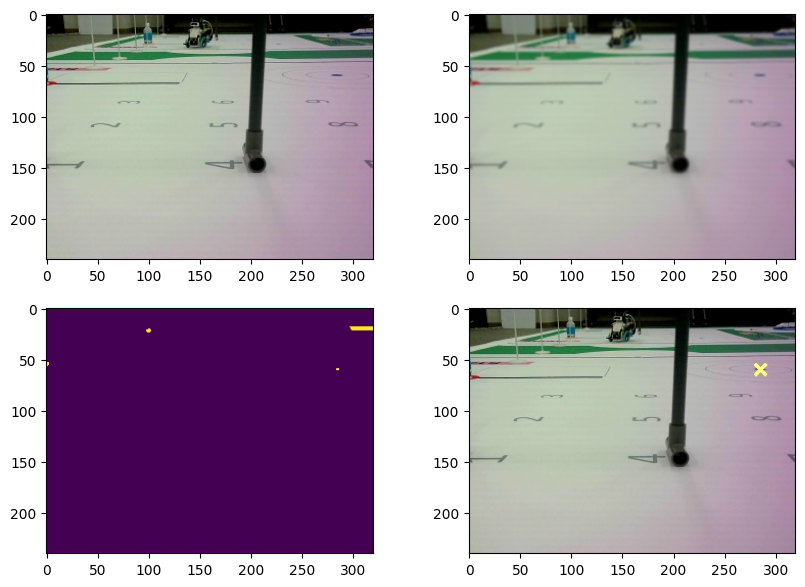

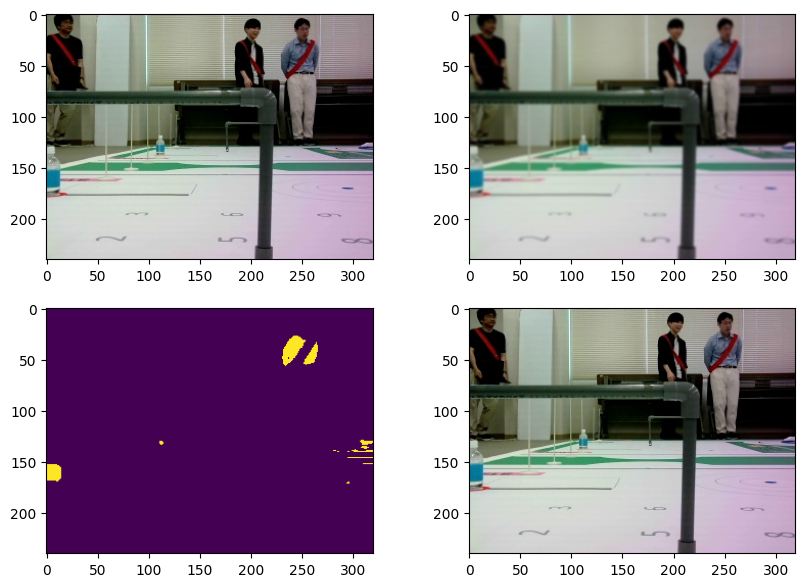

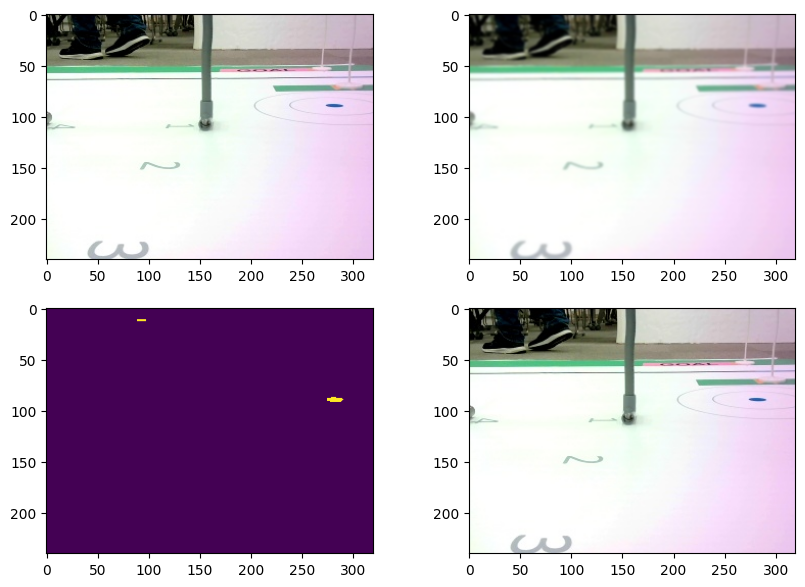

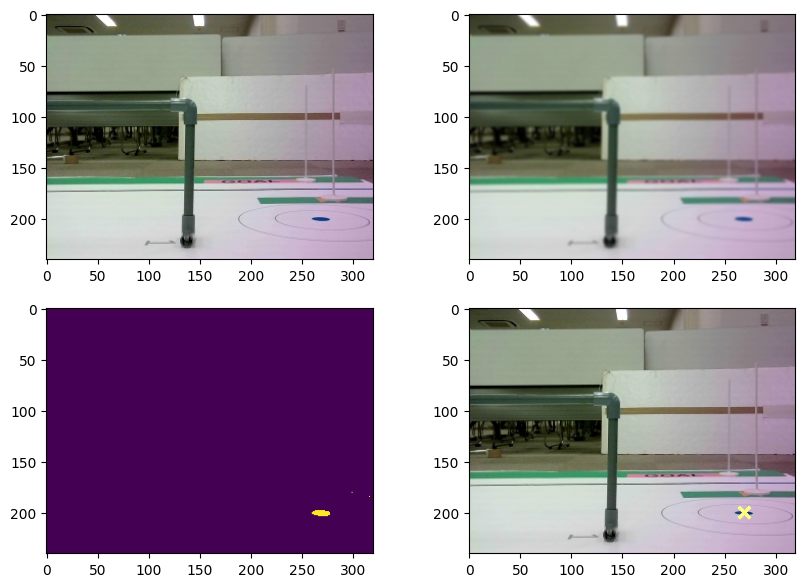

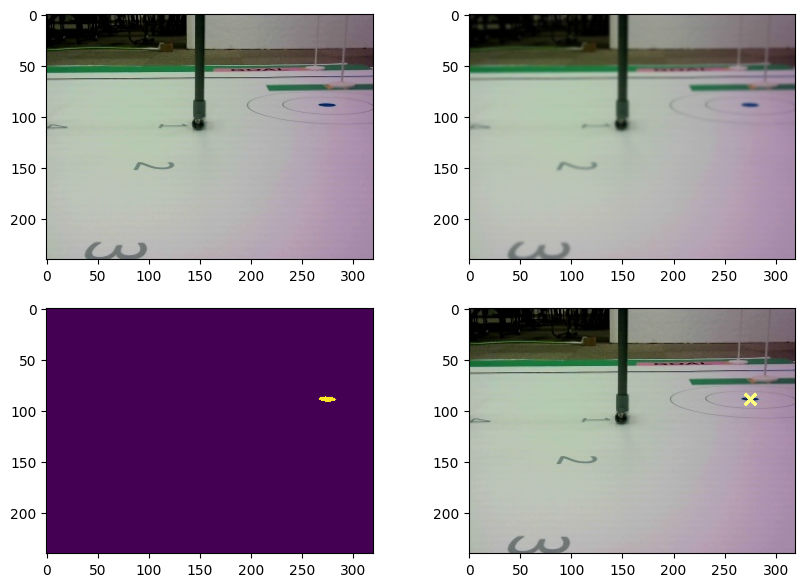

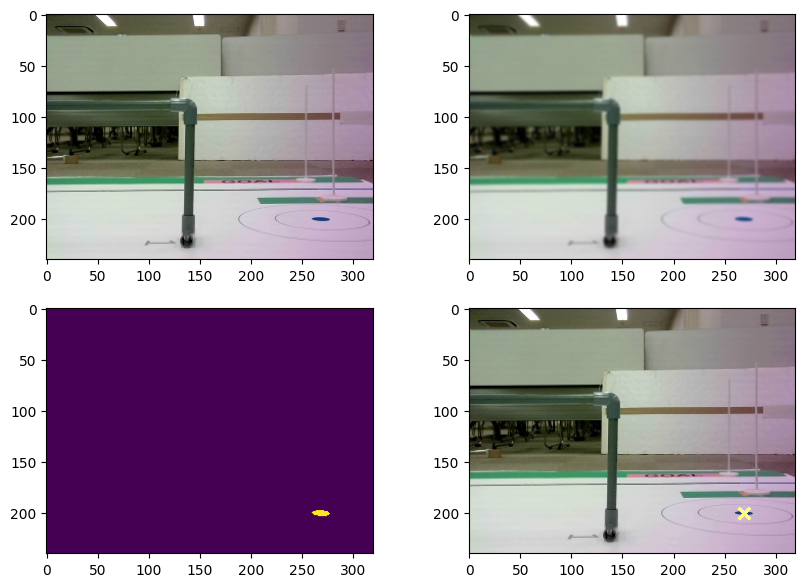

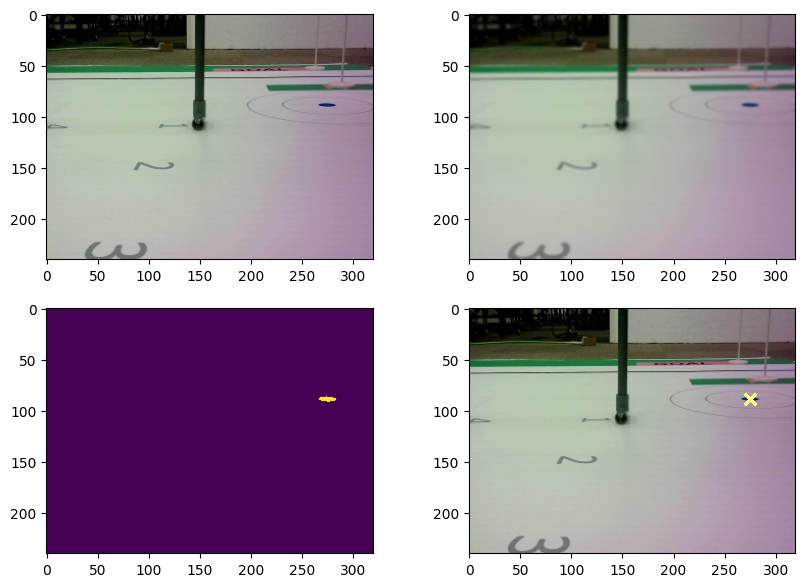

In [61]:
for img_name in file_names:
    print(img_name)
    analysis(img_name)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.25 μs
41 41


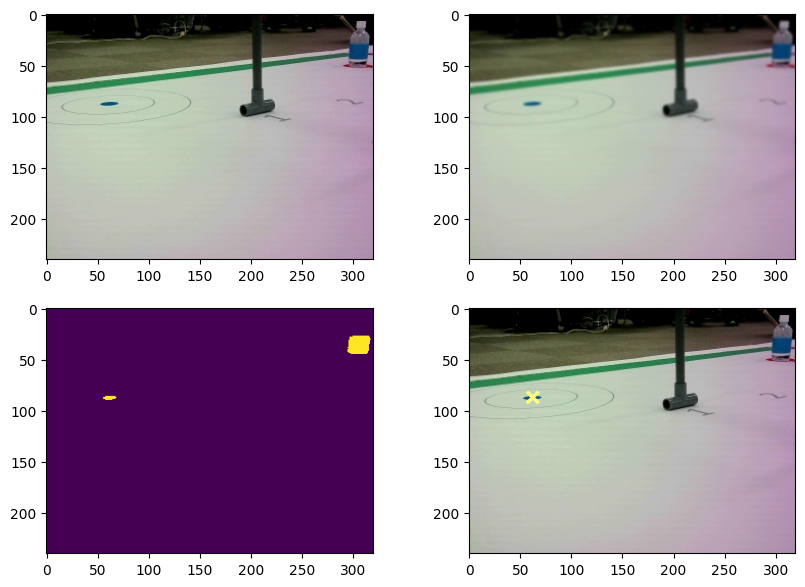

In [62]:
%time
analysis(file_names[0])